# Quantum fourier trasnformers for 3, 4, 5 qubits. including Inverse QFT
by: Vivek Vittal Biragoni 211AI041

In [34]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [35]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [36]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

"""Performs the Quantum Fourier Transform (QFT) on the first n qubits in the circuit.
    The QFT is implemented using recursive rotations and controlled phase shift gates.
    Args:
        circuit (QuantumCircuit): the quantum circuit on which to perform the QFT.
        n (int): the number of qubits on which to perform the QFT.
    Returns:
        QuantumCircuit: the input circuit with the QFT rotations applied.
    """

In [37]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit



# ** QFT for 3 qubits **

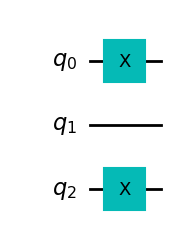

In [38]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

swap_registers swaps the qubits in the first n/2 positions with their respective complements in the last n/2 positions of a QuantumCircuit object circuit. The function iterates over the range of n/2 and applies the swap gate on each qubit and its complement.

qft applies the Quantum Fourier Transform (QFT) on the first n qubits of a QuantumCircuit object circuit. The function first performs QFT rotations on the first n qubits using the qft_rotations function, and then swaps the qubits using the swap_registers function. The modified QuantumCircuit object is returned.

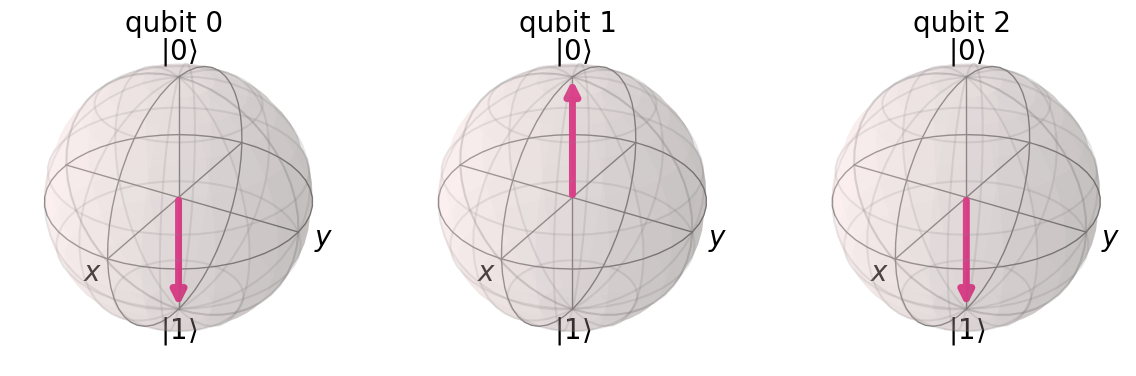

In [39]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

the code simulates the execution of the qc circuit on the aer_simulator backend, retrieves the resulting statevector, and displays it using a Bloch sphere visualization.

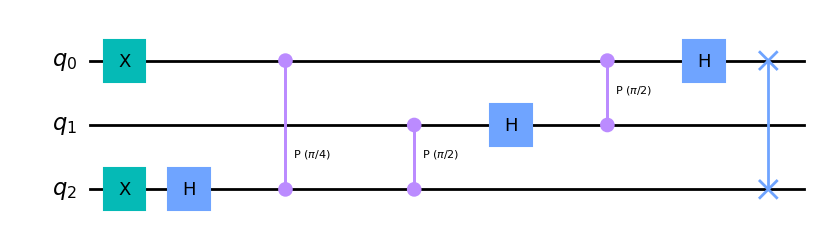

In [40]:
qft(qc,3)
qc.draw()

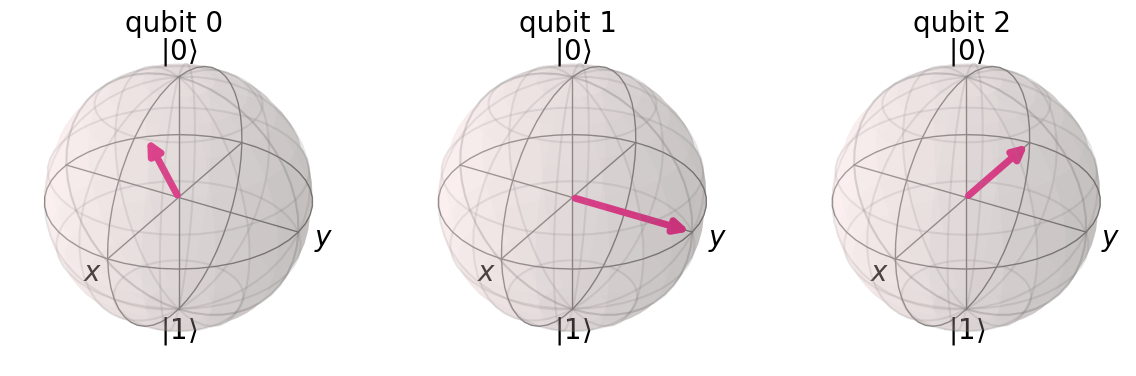

In [41]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

 the code simulates the execution of the qc circuit on the aer_simulator backend, retrieves the resulting statevector, and displays it using a Bloch sphere visualization. Note that the initial state of qc was not modified before this code, so the displayed Bloch sphere will show the statevector of the all-zero initial state.

In [42]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

The function does the following:

Calls the qft function defined earlier to create a QFT circuit of size n using a QuantumCircuit(n) object.
Takes the inverse of the QFT circuit using the .inverse() method.
Adds the inverse QFT circuit to the first n qubits in circuit using the .append() method.
Returns the resulting circuit with all gates decomposed using the .decompose() method.

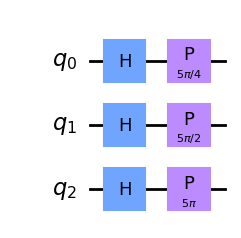

In [43]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

 creates a QuantumCircuit object qc with 3 qubits. It then applies the following operations to the qubits:

Applies a Hadamard gate (qc.h(qubit)) to each qubit in the circuit.

Applies phase gates (qc.p()) to the qubits as follows:

A phase gate with an angle of number*pi/4 is applied to the first qubit (qc.p(number*pi/4,0)).
A phase gate with an angle of number*pi/2 is applied to the second qubit (qc.p(number*pi/2,1)).
A phase gate with an angle of number*pi is applied to the third qubit (qc.p(number*pi,2)).
Finally, the circuit is drawn using the draw() method. The resulting circuit applies a quantum phase estimation (QPE) to the state |5⟩ using 3 qubits and a maximum rotation angle of 5*pi.

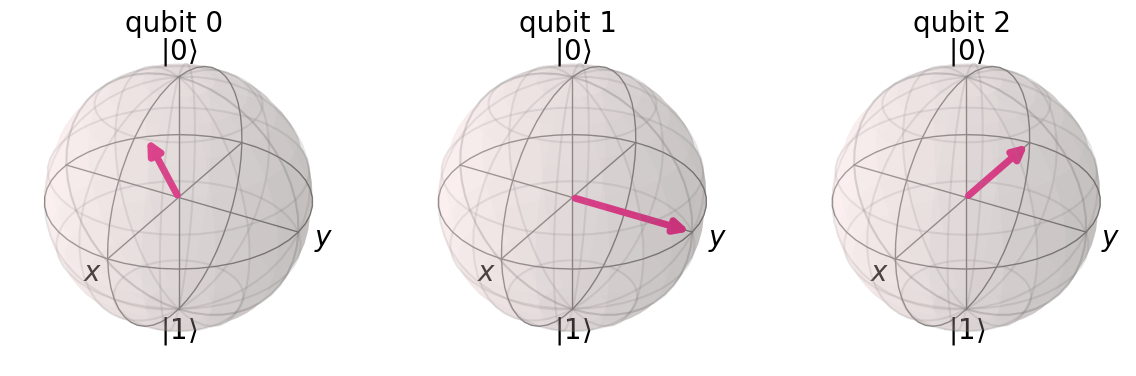

In [44]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

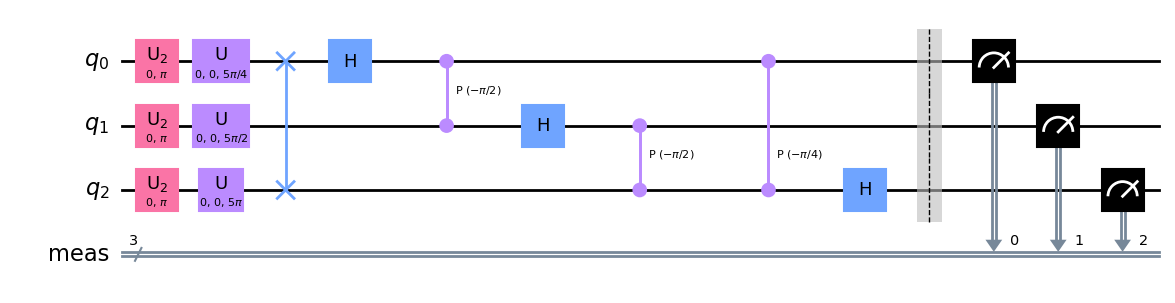

In [45]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

In [46]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2023-05-04 09:49:55,833: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_oslo


{'101': 2048}


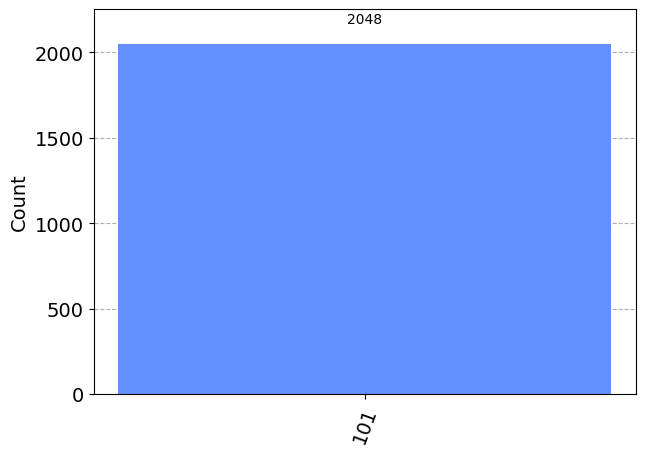

In [47]:
from qiskit import BasicAer
backend_qasm = BasicAer.get_backend('qasm_simulator')
job = backend_qasm.run(transpile(qc, backend_qasm), shots=2048)
counts=job.result().get_counts()
print(counts)
plot_histogram(counts)

code performs a simulation of the qc circuit on the qasm_simulator backend provided by the BasicAer module.

To run the simulation, the circuit qc is first transpiled using the transpile() function with the backend_qasm as the target backend. This is done to optimize the circuit for the specific backend.

The job object is then created by calling the .run() method of the backend_qasm object with the transpiled circuit as the argument and setting the number of shots to 2048.

The counts for each measurement outcome are then extracted from the result of the simulation using the .get_counts() method of the job.result() object, which returns a dictionary where the keys are the bitstrings measured and the values are the number of times that bitstring was measured.

Finally, the counts are plotted on a histogram using the plot_histogram() function from the qiskit.visualization module, which shows the relative frequency of each bitstring measured in the simulation.

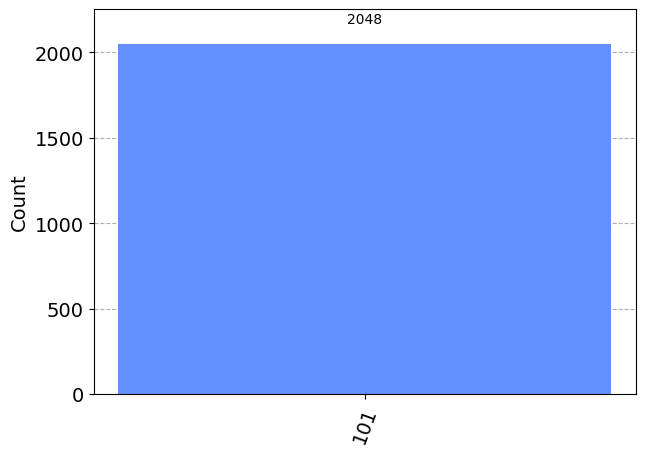

In [48]:
counts = job.result().get_counts()
plot_histogram(counts)

finally, verified using the inverse qft. and the probability of 5 is too high, since there is no noise in the circuit.

# ** QFT for 4 qubits **

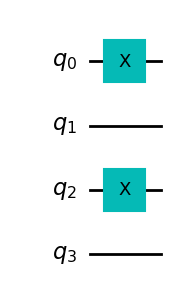

In [49]:
# Create the circuit
qc = QuantumCircuit(4)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

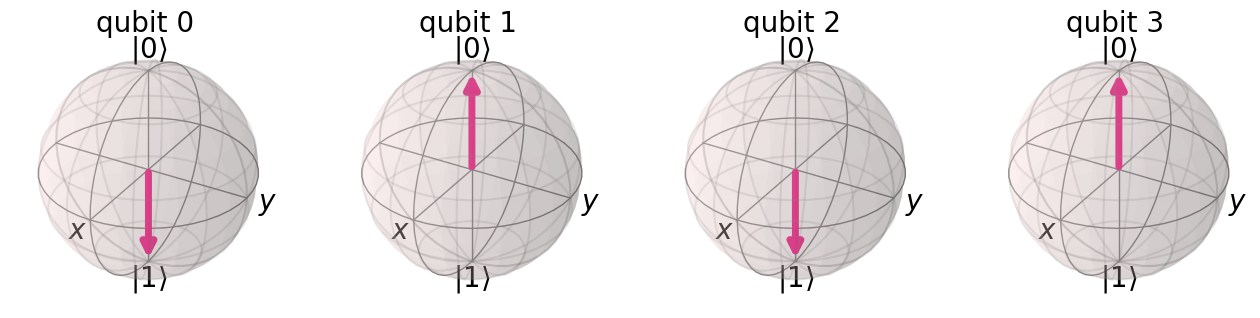

In [50]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

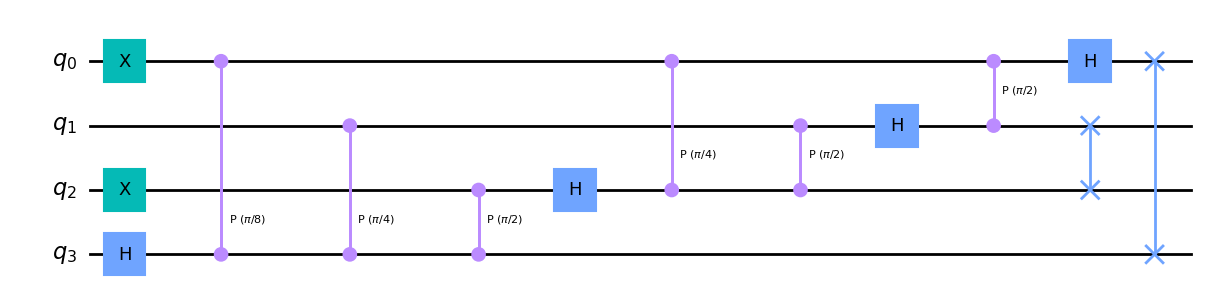

In [51]:
qft(qc,4)
qc.draw()

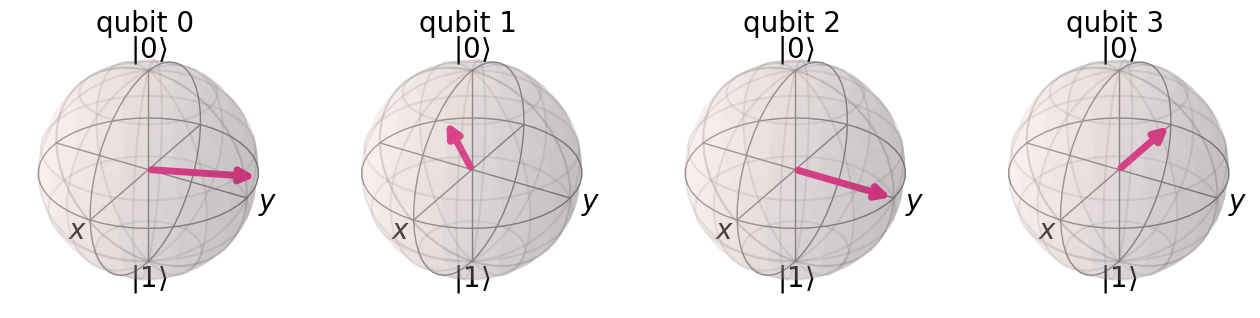

In [52]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

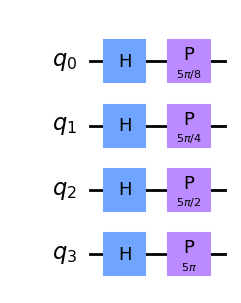

In [53]:
nqubits = 4
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/8,0)    
qc.p(number*pi/4,1)
qc.p(number*pi/2,2)
qc.p(number*pi,3)

qc.draw()

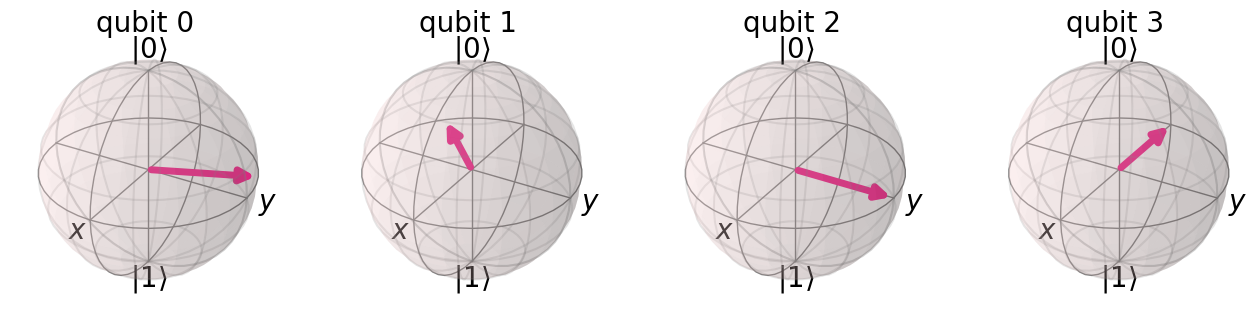

In [54]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

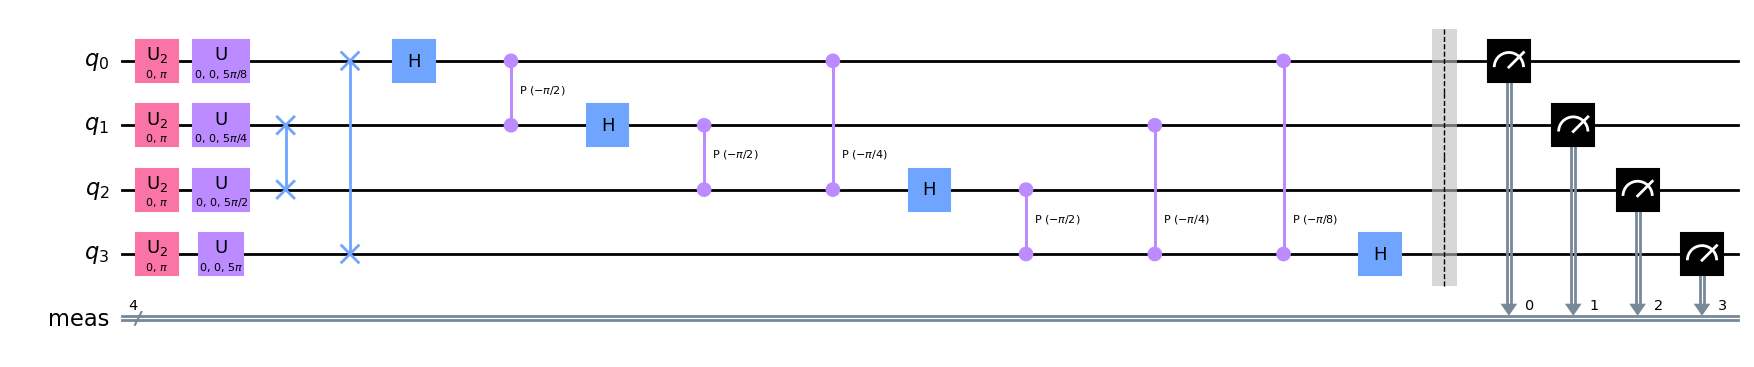

In [55]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

{'0101': 2048}


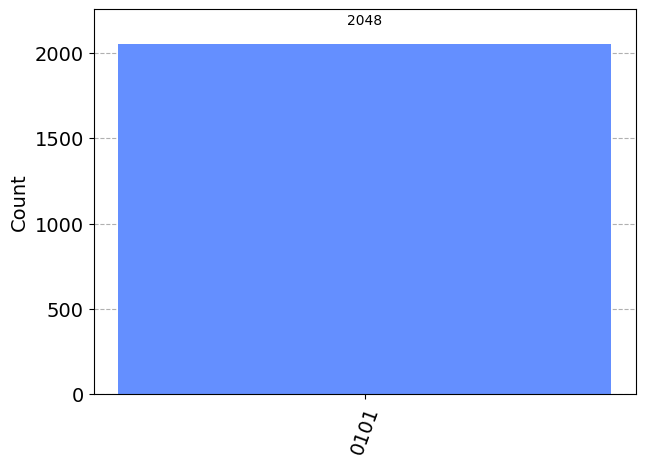

In [56]:
from qiskit import BasicAer
backend_qasm = BasicAer.get_backend('qasm_simulator')
job = backend_qasm.run(transpile(qc, backend_qasm), shots=2048)
counts=job.result().get_counts()
print(counts)
plot_histogram(counts)

finally, verified using the inverse qft. and the probability of 5 is too high, since there is no noise in the circuit.

# ** QFT for 5 qubits **

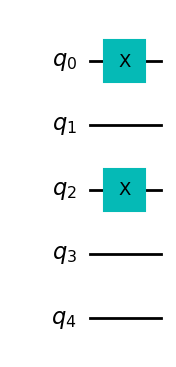

In [57]:
# Create the circuit
qc = QuantumCircuit(5)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

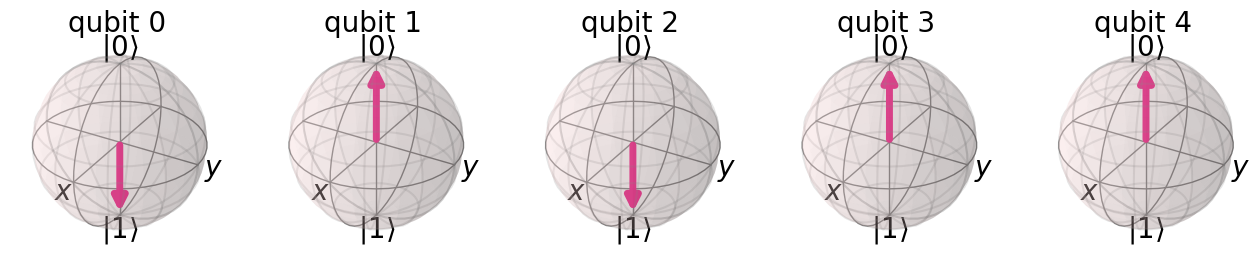

In [58]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

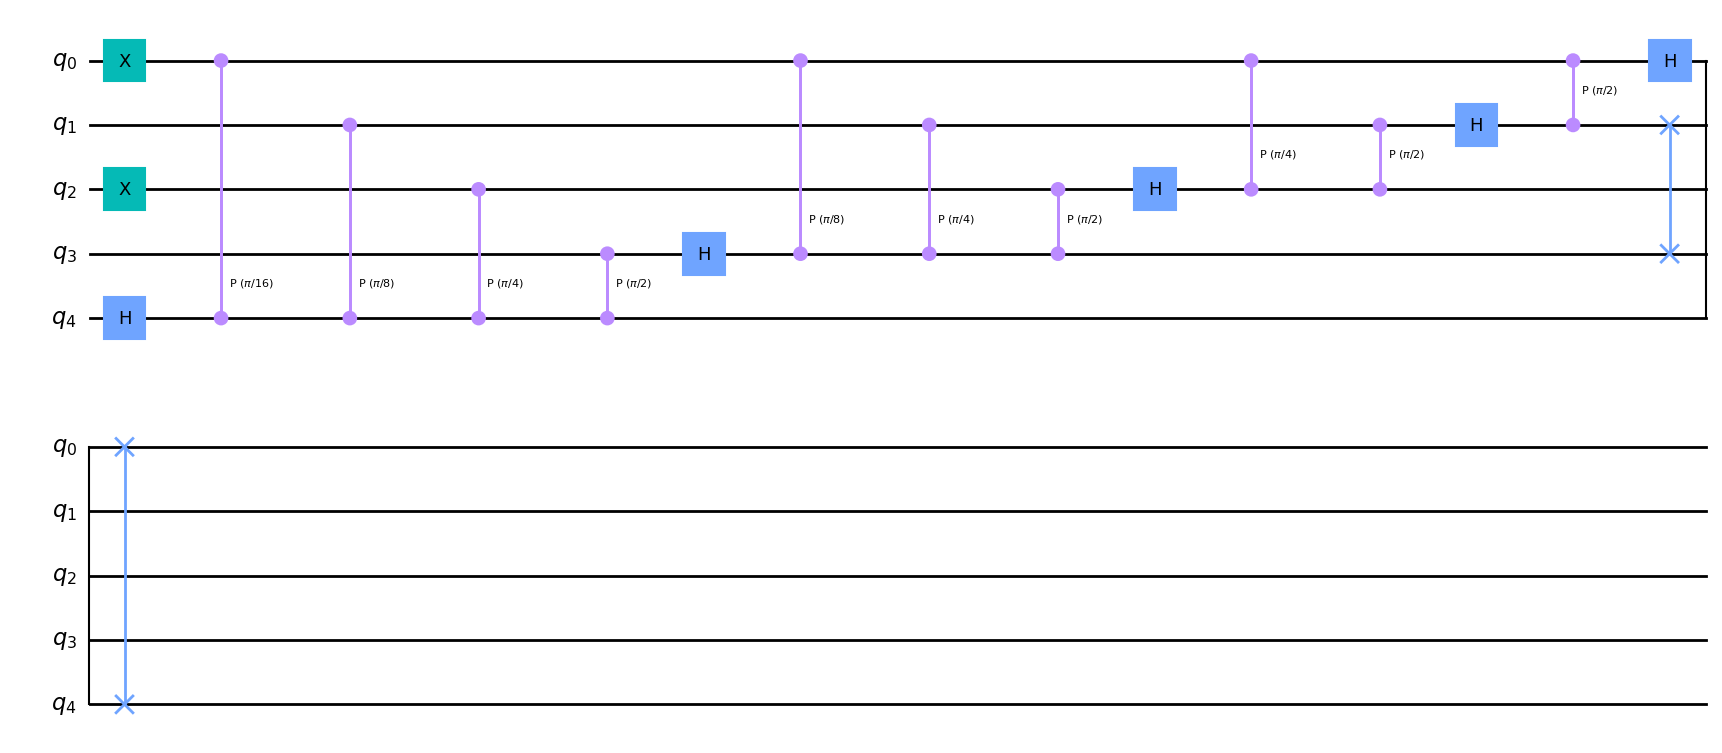

In [59]:
qft(qc,5)
qc.draw()

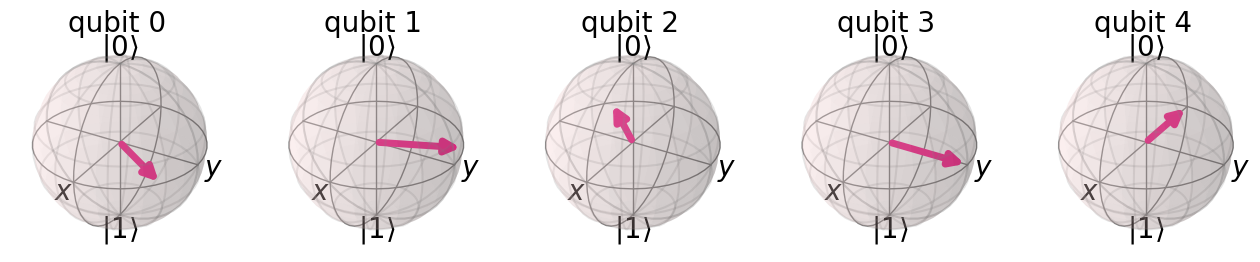

In [60]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

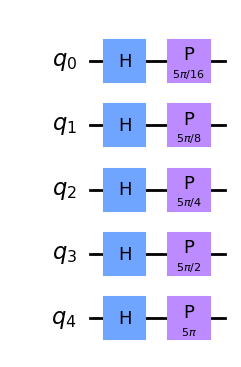

In [61]:
nqubits = 5
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/16,0)
qc.p(number*pi/8,1)    
qc.p(number*pi/4,2)
qc.p(number*pi/2,3)
qc.p(number*pi,4)

qc.draw()

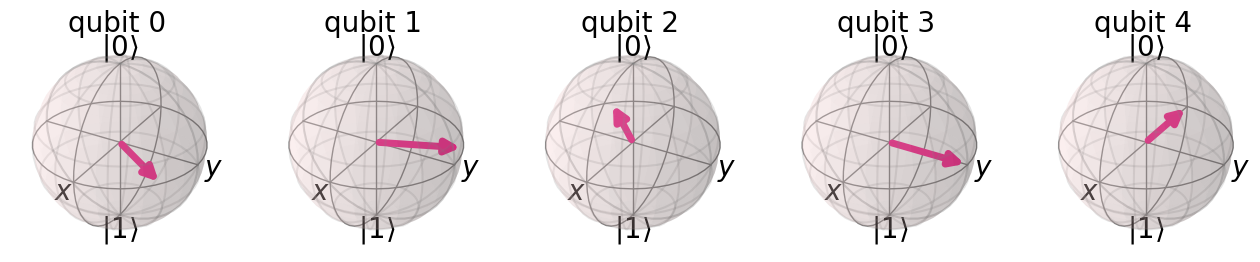

In [62]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

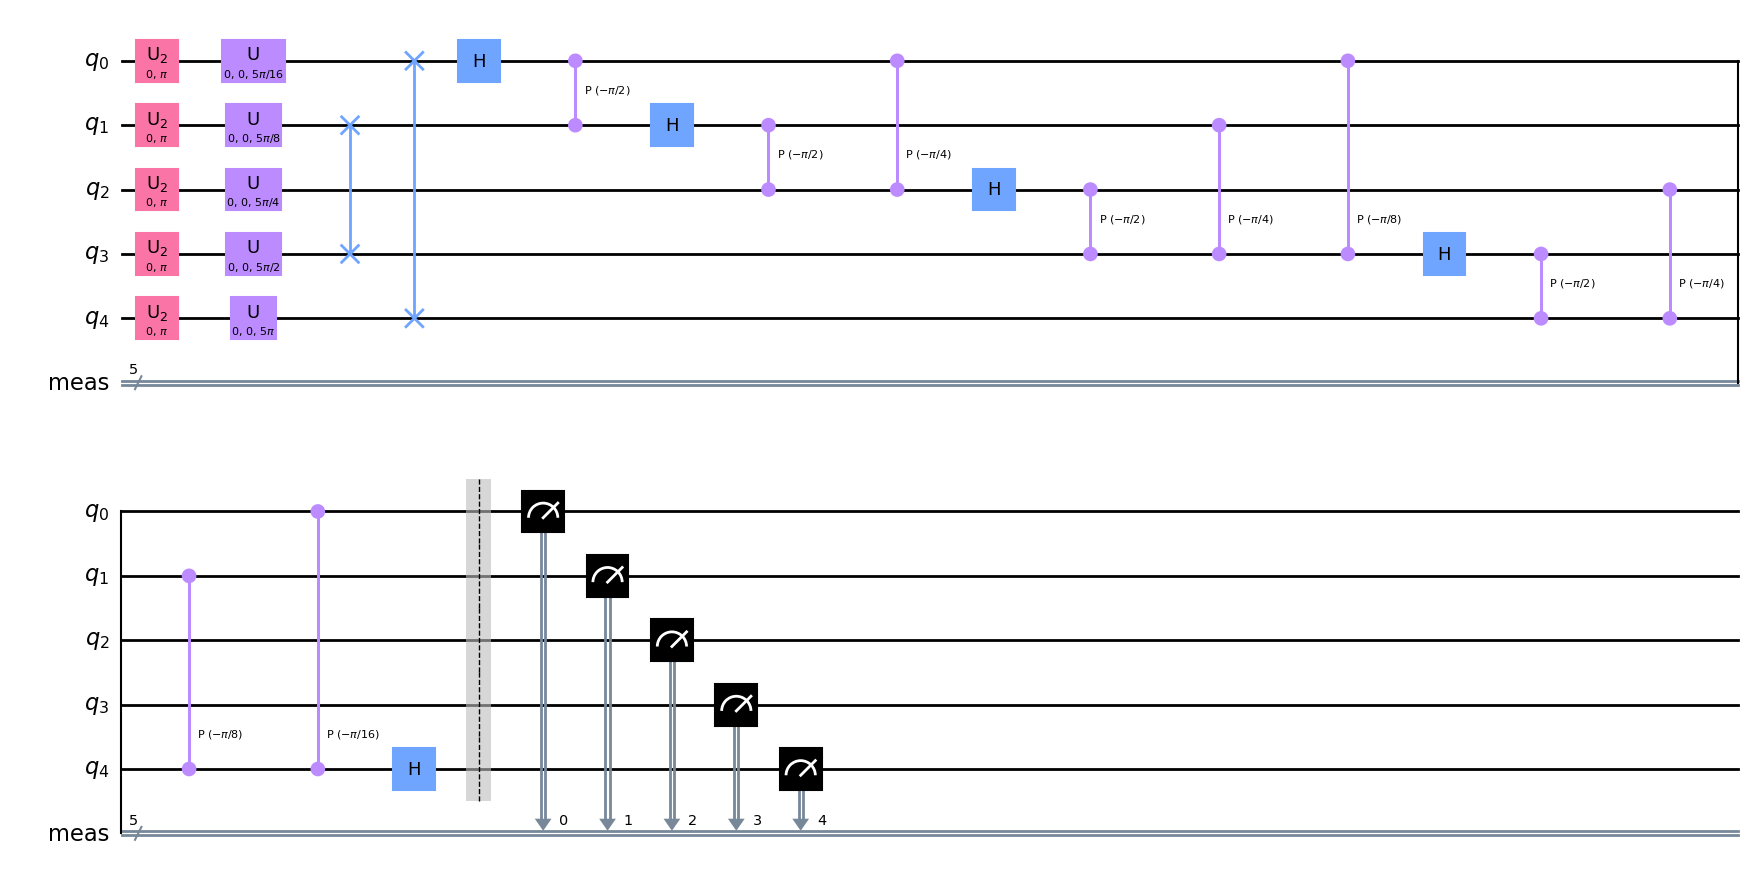

In [63]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

{'00101': 2048}


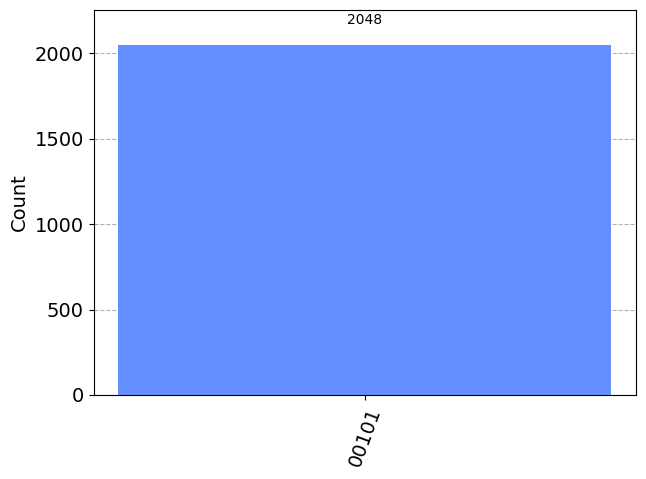

In [64]:
from qiskit import BasicAer
backend_qasm = BasicAer.get_backend('qasm_simulator')
job = backend_qasm.run(transpile(qc, backend_qasm), shots=2048)
counts=job.result().get_counts()
print(counts)
plot_histogram(counts)

finally, verified using the inverse qft. and the probability of 5 is too high, since there is no noise in the circuit.